In [2]:
#run pip install fancyimpute
#launch spark 
import pyspark
import dxpy
import dxdata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from fancyimpute import IterativeImputer
from scipy.stats import chi2_contingency
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/cluster/dnax/jars/dnanexus-api-0.1.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/cluster/spark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2023-09-19 21:51:46.615 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-09-19 21:51:47.693 WARN  Utils:69 - Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 43000. Attempting port 43001.
2023-09-19 21:51:47.966 WARN  MetricsReporter:84 - No metrics configured for reporting
2023-09-19 21:51:47.967 WARN  LineProtoUsageReporter:48 - Telegraf configurations: url [metrics.push.telegraf.hostport], user [metrics.push.telegraf.user] or password [metrics.push.telegraf.password] missing.
2023-09-19 21:51:47.967 WARN  MetricsReporter:117 - metrics.scraping.httpserver.port


In [3]:
#prep database 
dispensed_database_name = dxpy.find_one_data_object(classname="database", name="app*", folder="/", name_mode="glob", describe=True)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(typename="Dataset", name="app*.dataset", folder="/", name_mode="glob")["id"]

In [4]:
#prep dataset
dataset = dxdata.load_dataset(id=dispensed_dataset_id)
participant = dataset["participant"]

In [5]:
#pull all relevant columns
field_names = ["eid", "p31", "p22189", "p21000_i0", "p21001_i0", 'p21001_i1', 'p21003_i0',  'p21003_i1', "p1558_i0","p1558_i1", "p20002_i0",  "p131298", "p6150_i0", "p131286", "p131294", "p130814", "p130706", "p130708", "p53_i0",  "p53_i1",  "p130892", "p130894", "p130896", "p2050_i0", "p2060_i0",  "p2050_i1",  "p130838", "p131056", "p131058", "p131180", "p131360", "p131362", "p131364", "p131366", "p131368", "p131370", "p131372", "p131374", "p131376", "p131378", "p22032_i0", 'p21001_i1', 'p1558_i1', 'p21003_i1',  'p21003_i1', 'p20116_i0', 'p20116_i1', 'p20003_i0', 'p1160_i0', 'p20003_i1', 'p1160_i1', 'p1070_i0', 'p1070_i1', 'p1080_i0', 'p1080_i1', 'p1120_i0', 'p1120_i1', 'p110005', 'p90051' , 'p90016', 'p90017', 'p90185', 'p90187', 'p90012', 'p90010', 'p90011', 'p6142_i0' , 'p134_i0', 'p131354', 'p131306', 'p40046_i0', 'p40047_i0', 'p40048_i0', 'p40049_i0', 'p90027', 'p90028', 'p90029', 'p90030', 'p90031', 'p90032', 'p90033', 'p90034', 'p90035', 'p90036', 'p90037', 'p90038', 'p90039', 'p90040', 'p90041', 'p90042', 'p90043', 'p90044', 'p90045', 'p90046', 'p90047', 'p90048', 'p90049', 'p90050', 'p90051', 'p40030_i0', 'p40031_i0', 'p40032_i0', 'p40033_i0', 'p6146_i0', 'p134_i1', 'p20002_i1', 'p22040_i0']
df = participant.retrieve_fields(names=field_names, engine=dxdata.connect())

2023-09-19 21:51:59.546 WARN  ShellBasedUnixGroupsMapping:210 - unable to return groups for user y8bFk6BpbyJVJBX0bKy7JGP0fKQ54pzxkfx6V2x6__project-GG7jpPjJ4VK0VKqV89494XV5
PartialGroupNameException The user name 'y8bFk6BpbyJVJBX0bKy7JGP0fKQ54pzxkfx6V2x6__project-GG7jpPjJ4VK0VKqV89494XV5' is not found. id: ‘y8bFk6BpbyJVJBX0bKy7JGP0fKQ54pzxkfx6V2x6__project-GG7jpPjJ4VK0VKqV89494XV5’: no such user
id: ‘y8bFk6BpbyJVJBX0bKy7JGP0fKQ54pzxkfx6V2x6__project-GG7jpPjJ4VK0VKqV89494XV5’: no such user

	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.resolvePartialGroupNames(ShellBasedUnixGroupsMapping.java:294)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getUnixGroups(ShellBasedUnixGroupsMapping.java:207)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getGroups(ShellBasedUnixGroupsMapping.java:97)
	at org.apache.hadoop.security.JniBasedUnixGroupsMappingWithFallback.getGroups(JniBasedUnixGroupsMappingWithFallback.java:51)
	at org.apache.hadoop.security.Groups$Gro

In [6]:
#create pandas dataframe
pdf = df.toPandas()

2023-09-19 21:52:30.913 WARN  package:69 - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


/cluster/spark/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/cluster/spark/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/cluster/spark/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/cluster/spark/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

In [7]:
#check that pandas conversion worked - this is the full UKBB rows of px
#pdf.head(10)
len(pdf)

502364

In [8]:
#rename columns
pdf_rename = pdf.rename(columns={'eid': 'pID', 'p31': 'male', 'p22189': 'tdi', 'p21000_i0': 'ethnicity', 'p21001_i0': 'bmi', 'p21001_i1': 'bmi_1', 'p1558_i0': 'alc_freq', 'p1558_i1': 'alc_freq_1', 'p20002_i0': 'sr_illness', 'p21003_i0': 'age_i0', 'p21003_i1': 'age_i1',  'p131298': 'i21_date', 'p6150_i0': 'vasc_diag', 'p131298': 'i21_date', 'p131286': 'i10_date', 'p131294': 'i15_date', 'p130814': 'e78_date', 'p130706': 'e10_date', 'p130708': 'e11_date', 'p53_i0': 'date_i0', 'p53_i1': 'date_i1', 'p41271': 'icd9', 'p41270': 'icd10', 'p130892': 'f31_date',  'p130894': 'f32_date', 'p130896': 'f33_date', 'p2050_i0': 'phq2_1', 'p130838': 'f01_date', 'p131056': 'g45_date', 'p131058': 'g46_date', 'p131180': 'h34_date', 'p131360': 'i60_date', 'p131362': 'i61_date', 'p131364': 'i62_date', 'p131366': 'i63_date', 'p131368': 'i64_date', 'p131370': 'i65_date', 'p131372': 'i66_date', 'p131374': 'i67_date', 'p131376': 'i68_date', 'p131378': 'i69_date', 'p20116_i0': 'smok_stat', "p20116_i1": 'smok_stat_1', 'p1160_i0': 'sleep', 'p1160_i1': 'sleep_1', 'p1070_i0':'tv', 'p1070_i1':'tv_1', 'p1080_i0':'computer', 'p1080_i1':'computer_1', 'p1120_i0': 'mobile phone', 'p1120_i1': 'mobile phone_1', 'p20510': 'phq2_1_1', 'p22032_i0': 'ipaq', 'p2050_i1': 'phq2_1_followup', 'p90012': 'aac_overall_avg', 'p90185': 'acc_exceed8g_aftercal', 'p90187': 'acc_total_data_read', 'p90017': 'acc_calib_own', 'p90016': 'acc_calib_all', 'p90051': 'acc_weartime', 'p90010': 'acc_start_date', 'p90011': 'acc_end_date', 'p6142_i0': 'employ_status',  'p131354': 'i50_date', 'p131306': 'i25_date', 'p40046_i0': 'pa_sleep_over_avg', 'p40047_i0': 'pa_seden_over_avg', 'p40048_i0': 'pa_light_over_avg',  'p40049_i0': 'pa_mv_over_avg', 'p40049_i0': 'pa_mv_over_avg', 'p90027':'pa_time_1', 'p90028':'pa_time_2', 'p90029':'pa_time_3', 'p90030':'pa_time_4', 'p90031':'pa_time_5', 'p90032':'pa_time_6', 'p90033':'pa_time_7', 'p90034':'pa_time_8', 'p90035':'pa_time_9', 'p90036':'pa_time_10', 'p90037':'pa_time_11', 'p90038':'pa_time_12', 'p90039':'pa_time_13', 'p90040':'pa_time_14', 'p90041':'pa_time_15', 'p90042':'pa_time_16', 'p90043':'pa_time_17', 'p90044':'pa_time_18', 'p90045':'pa_time_19', 'p90046':'pa_time_20', 'p90047':'pa_time_21', 'p90048':'pa_time_22', 'p90049':'pa_time_23', 'p90050':'pa_time_24', 'p90051': 'pa_sum_wear', 'p40030_i0': 'pa_sleep_day_hour', 'p40031_i0': 'pa_sed_day_hour', 'p40032_i0': 'pa_light_day_hour', 'p40033_i0': 'pa_mv_day_hour', 'p6146_i0': 'gov_assistance', 'p20002_i1':'sr_illness_1', 'p22040_i0': 'met_minweek'})
#check that rename worked
pdf_rename.head(5)

,pID,male,tdi,ethnicity,bmi,bmi_1,age_i0,age_i1,alc_freq,alc_freq_1,...,pa_time_23,pa_time_24,pa_sleep_day_hour,pa_sed_day_hour,pa_light_day_hour,pa_mv_day_hour,gov_assistance,p134_i1,sr_illness_1,met_minweek
0,5545411,1,-4.62,1001.0,28.8906,NaN,59,NaN,3.0,NaN,...,15.48,8.51,"0.96,0.97,0.95,0.96,1,1,0.95,0.57,0.17,0.07,0,...","0.01,0.03,0.05,0.04,0,0,0.01,0.34,0.62,0.45,0....","0.03,0,0,0,0,0,0.04,0.09,0.21,0.35,0.33,0.22,0...","0,0,0,0,0,0,0,0,0,0.13,0.15,0.34,0.16,0,0.02,0...",[-7],NaN,None,NaN
1,5180517,0,-0.42,1001.0,22.7933,NaN,52,NaN,5.0,NaN,...,31.26,32.41,"0.98,1,1,1,1,1,1,0.44,0.02,0.14,0,0,0.04,0.12,...","0.02,0,0,0,0,0,0,0.46,0.52,0.22,0.28,0.33,0.5,...","0,0,0,0,0,0,0,0.11,0.46,0.58,0.57,0.57,0.35,0....","0,0,0,0,0,0,0,0,0,0.05,0.15,0.1,0.1,0.13,0.07,...",[-7],NaN,None,NaN
2,1668262,1,-4.35,1001.0,25.3439,NaN,61,NaN,3.0,NaN,...,NaN,NaN,None,None,None,None,[-7],NaN,None,99.0
3,2151806,0,-3.06,1001.0,32.7087,NaN,57,NaN,4.0,NaN,...,NaN,NaN,None,None,None,None,[-7],NaN,None,594.0
4,4202281,0,8.22,1001.0,24.2078,NaN,51,NaN,1.0,NaN,...,NaN,NaN,None,None,None,None,[2],NaN,None,99.0


In [9]:
pdf_rename['met_minweek'] = pd.to_numeric(pdf_rename['met_minweek'], errors='coerce')
pdf_rename['met_minweek_filter'] = pdf_rename['met_minweek']/7
pdf_rename['met_minweek_filter'] = pdf_rename['met_minweek_filter']/60
pdf_rename.dropna(subset=['met_minweek_filter'], inplace=True)

In [10]:
#convert ethnicity data to be workable
pdf_rename['ethnicity'].dtype
pdf_rename['ethnicity'] = pd.to_numeric(pdf_rename['ethnicity'], errors='coerce')
pdf_rename['ethnicity'].dtype
for index, row in pdf_rename.iterrows():
    if row['ethnicity'] == 1.0 or row['ethnicity'] == 1001.0 or row['ethnicity'] == 1002.0 or row['ethnicity'] == 1003.0:
        pdf_rename.at[index, 'white_yes'] = 1

In [11]:
#drop -1 ("do not know") and -3 ("prefer not to answer") from sleep duration survey
pdf_rename = pdf_rename[~(pdf_rename['sleep'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['sleep'] == -1)]
print('after dropping px with missing sleep survey data', len(pdf_rename))

after dropping px with missing sleep survey data 384383


In [12]:
#for smoking status, drop anyone who answered "-3/prefer not to answer"
pdf_rename['smok_stat'] = pdf_rename['smok_stat'].astype(str)
pdf_rename = pdf_rename[~pdf_rename['smok_stat'].str.contains('-3')]
print('after dropping px with missing smoking survey data', len(pdf_rename))

after dropping px with missing smoking survey data 383441


In [13]:
#drop -1 and -3 from tv and computer and mobile phone use; fix tv use value of -10
pdf_rename = pdf_rename[~(pdf_rename['tv'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['tv'] == -1)]
pdf_rename = pdf_rename[~(pdf_rename['computer'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['computer'] == -1)]
pdf_rename = pdf_rename[~(pdf_rename['mobile phone'] == -3)]
pdf_rename = pdf_rename[~(pdf_rename['mobile phone'] == -1)]
pdf_rename['tv'] = pdf_rename['tv'].replace(-10, 0.5)
print('after dropping px with incomplete screen surveys data', len(pdf_rename))

after dropping px with incomplete screen surveys data 379604


In [14]:
pdf_rename.dropna(subset=['computer', 'tv', 'mobile phone'], inplace=True)
print('after dropping px with missing sleep survey data', len(pdf_rename))

after dropping px with missing sleep survey data 324750


In [15]:
#drop alc_freq values for "prefer not to answer"/-3
pdf_rename = pdf_rename[~(pdf_rename['alc_freq'] == -3)]
print('after dropping px with incomplete alcohol survey data', len(pdf_rename))

after dropping px with incomplete alcohol survey data 324638


In [16]:
#reorder alc_freq values 
#if 4	One to three times a month | 5	Special occasions only | 6	Never, then make seldom=1
#if 2	Three or four times a week | 3	Once or twice a week, then make sometimes=2
#if 1	Daily or almost daily, then make daily=3
pdf_rename['alc_freq_filter'] = np.where(pdf_rename['alc_freq'].isin([4, 5, 6]), 1, 
                    np.where(pdf_rename['alc_freq'].isin([2, 3]), 2, 
                             np.where(pdf_rename['alc_freq'].isin([1]), 3, np.nan)))

In [17]:
#drop phq2 scores where response was "-3/prefer not to answer"
pdf_rename = pdf_rename.drop(pdf_rename.loc[pdf_rename['phq2_1'] < -1].index)
len(pdf_rename)

323670

In [18]:
# replace all occurrences of -1 (do not know if depressed) in column PHQ2_1 and PHQ2_2 with 0
pdf_rename['phq2_1'] = pdf_rename['phq2_1'].replace(-1, 0)
len(pdf_rename)

323670

In [19]:
#convert sr_illness to string
pdf_rename['sr_illness'].dtype
pdf_rename['sr_illness'] = pdf_rename['sr_illness'].astype(str)
#remove 1075= heart attack, 1081= stroke, 1082= tia, 1086= sah, 1282= brao/crao, 1491= brain hemorrhage, 1583= ischemic stroke
pdf_rename = pdf_rename[~pdf_rename['sr_illness'].str.contains('1075|1081|1082|1086|1282|1491|1583')]
print('after dropping px with self-reported HA or CeVD prior to baseline', len(pdf_rename))

after dropping px with self-reported HA or CeVD prior to baseline 312617


In [20]:
#convert dates to datetime values or analysis
pdf_rename["date_i0"] = pd.to_datetime(pdf_rename["date_i0"])
pdf_rename["i21_date"] = pd.to_datetime(pdf_rename["i21_date"])
pdf_rename["f01_date"] = pd.to_datetime(pdf_rename["f01_date"])
pdf_rename["g45_date"] = pd.to_datetime(pdf_rename["g45_date"])
pdf_rename["g46_date"] = pd.to_datetime(pdf_rename["g46_date"])
pdf_rename["h34_date"] = pd.to_datetime(pdf_rename["h34_date"])
pdf_rename["i60_date"] = pd.to_datetime(pdf_rename["i60_date"])
pdf_rename["i61_date"] = pd.to_datetime(pdf_rename["i61_date"])
pdf_rename["i62_date"] = pd.to_datetime(pdf_rename["i62_date"])
pdf_rename["i63_date"] = pd.to_datetime(pdf_rename["i63_date"])
pdf_rename["i64_date"] = pd.to_datetime(pdf_rename["i64_date"])
pdf_rename["i65_date"] = pd.to_datetime(pdf_rename["i65_date"])
pdf_rename["i66_date"] = pd.to_datetime(pdf_rename["i66_date"])
pdf_rename["i67_date"] = pd.to_datetime(pdf_rename["i67_date"])
pdf_rename["i68_date"] = pd.to_datetime(pdf_rename["i68_date"])
pdf_rename["i69_date"] = pd.to_datetime(pdf_rename["i69_date"])
pdf_rename["f31_date"] = pd.to_datetime(pdf_rename["f31_date"])
pdf_rename["f32_date"] = pd.to_datetime(pdf_rename["f32_date"])
pdf_rename["f33_date"] = pd.to_datetime(pdf_rename["f33_date"])

In [21]:
#drop px with prior heart attack (HA) 
#convert date columns to days format
pdf_rename['i21_time'] = (pdf_rename['date_i0'] - pdf_rename['i21_date']).dt.days
#drop cases with a prior heart attack (I21)
pdf_rename = pdf_rename.loc[(pdf_rename['i21_time'] < 0) | (pdf_rename['i21_time'].isna())]
print('after dropping px with medical record HA prior to baseline', len(pdf_rename))

after dropping px with medical record HA prior to baseline 312394


In [22]:
#convert vasc_diag to string
pdf_rename['vasc_diag'].dtype
pdf_rename['vasc_diag'] = pdf_rename['vasc_diag'].astype(str)
#drop px who report prior vascular diagnoses of HA, STROKE, PREFER NOT TO ANSWER
pdf_rename = pdf_rename.loc[(pdf_rename['vasc_diag'] == '[-7]') | (pdf_rename['vasc_diag']  == '[4]') | (pdf_rename['vasc_diag']  == '[2]')]
print('after dropping px with other self-report question on HA/stroke/prefer not to answer prior to baseline', len(pdf_rename))

after dropping px with other self-report question on HA/stroke/prefer not to answer prior to baseline 308621


In [23]:
#check cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['g45_time'] = (pdf_rename['date_i0'] - pdf_rename['g45_date']).dt.days
pdf_rename_check_g45 = pdf_rename.loc[(pdf_rename['g45_time'] > 0)]
print('check number of px with TIA prior to baseline', len(pdf_rename_check_g45))
#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['i63_time'] = (pdf_rename['date_i0'] - pdf_rename['i63_date']).dt.days
pdf_rename_check_i63 = pdf_rename.loc[(pdf_rename['i63_time'] > 0)]
print('check number of px with I63 prior to baseline', len(pdf_rename_check_i63))
#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['i64_time'] = (pdf_rename['date_i0'] - pdf_rename['i64_date']).dt.days
pdf_rename_check_i64 = pdf_rename.loc[(pdf_rename['i64_time'] > 0)]
print('check number of px with I64  prior to baseline', len(pdf_rename_check_i64))

check number of px with TIA prior to baseline 569
check number of px with I63 prior to baseline 58
check number of px with I64  prior to baseline 106


In [24]:
#drop prior CevD px who have recorded diagnosis in medical records
#drop cases with a prior vascular dementia (F01)
pdf_rename['f01_time'] = (pdf_rename['date_i0'] - pdf_rename['f01_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['f01_time'] < 0) | (pdf_rename['f01_time'].isna())]

#drop cases with a prior TIA (G45)
pdf_rename['g45_time'] = (pdf_rename['date_i0'] - pdf_rename['g45_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['g45_time'] < 0) | (pdf_rename['g45_time'].isna())]

#drop cases with a prior vascular brain syndromes of CeVD (G46)
pdf_rename['g46_time'] = (pdf_rename['date_i0'] - pdf_rename['g46_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['g46_time'] < 0) | (pdf_rename['g46_time'].isna())]

#drop cases with a prior RAO (H34)
pdf_rename['h34_time'] = (pdf_rename['date_i0'] - pdf_rename['h34_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['h34_time'] < 0) | (pdf_rename['h34_time'].isna())]

#drop cases with a prior Nontraumatic subarachnoid hemorrhage (I60)
pdf_rename['i60_time'] = (pdf_rename['date_i0'] - pdf_rename['i60_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i60_time'] < 0) | (pdf_rename['i60_time'].isna())]

#drop cases with a prior Nontraumatic intracerebral hemorrhage (I61)
pdf_rename['i61_time'] = (pdf_rename['date_i0'] - pdf_rename['i61_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i61_time'] < 0) | (pdf_rename['i61_time'].isna())]

#drop cases with a prior Other and unspecified nontraumatic intracranial hemorrhage (I62)
pdf_rename['i62_time'] = (pdf_rename['date_i0'] - pdf_rename['i62_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i62_time'] < 0) | (pdf_rename['i62_time'].isna())]

#drop cases with a prior intracerebral infarction (I63)
pdf_rename['i63_time'] = (pdf_rename['date_i0'] - pdf_rename['i63_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i63_time'] < 0) | (pdf_rename['i63_time'].isna())]

#drop cases with a prior unspecified stroke (I64)
pdf_rename['i64_time'] = (pdf_rename['date_i0'] - pdf_rename['i64_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i64_time'] < 0) | (pdf_rename['i64_time'].isna())]

#drop cases with a prior occlusion/stenosis precerebral arteries (I65)
pdf_rename['i65_time'] = (pdf_rename['date_i0'] - pdf_rename['i65_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i65_time'] < 0) | (pdf_rename['i65_time'].isna())]

#drop cases with a prior occlusion/stenosis cerebral arteries (I66)
pdf_rename['i66_time'] = (pdf_rename['date_i0'] - pdf_rename['i66_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i66_time'] < 0) | (pdf_rename['i66_time'].isna())]

#drop cases with a prior Other cerebrovascular diseases (I67)
pdf_rename['i67_time'] = (pdf_rename['date_i0'] - pdf_rename['i67_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i67_time'] < 0) | (pdf_rename['i67_time'].isna())]

#drop cases with a prior Cerebrovascular disorders in diseases classified elsewhere (I68)
pdf_rename['i68_time'] = (pdf_rename['date_i0'] - pdf_rename['i68_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i68_time'] < 0) | (pdf_rename['i68_time'].isna())]

#drop cases with a prior Sequelae of cerebrovascular disease (I69)
pdf_rename['i69_time'] = (pdf_rename['date_i0'] - pdf_rename['i69_date']).dt.days
pdf_rename = pdf_rename.loc[(pdf_rename['i69_time'] < 0) | (pdf_rename['i69_time'].isna())]

print('after dropping px with CeVD diagnoses in medical records prior to baseline', len(pdf_rename))

after dropping px with CeVD diagnoses in medical records prior to baseline 307008


In [25]:
#prep depression cases in "days" format
pdf_rename['f31_time'] = (pdf_rename['date_i0'] - pdf_rename['f31_date']).dt.days
pdf_rename['f32_time'] = (pdf_rename['date_i0'] - pdf_rename['f32_date']).dt.days
pdf_rename['f33_time'] = (pdf_rename['date_i0'] - pdf_rename['f33_date']).dt.days
# check for diagnosed depression; if yes, return 1
def check_for_dep_diag(row):
    if row['f31_time'] > 0 or row['f32_time'] > 0 or row['f33_time'] > 0:
        return 1
    else:
        return 0

pdf_rename['dep_diag_yes'] = pdf_rename.apply(check_for_dep_diag, axis=1)
check_dep_diag = pdf_rename['dep_diag_yes'].sum()
print("Number of px with depression diagnosis (F31, F32, F33):", check_dep_diag)

Number of px with depression diagnosis (F31, F32, F33): 24971


In [26]:
#pull earliest depression diagnosis per row; make depression duration variable
pdf_rename['dep_dur'] = pdf_rename[['f31_time', 'f32_time', 'f33_time']].max(axis=1)
print("median depression duration:", pdf_rename['dep_dur'].median())

median depression duration: 1562.0


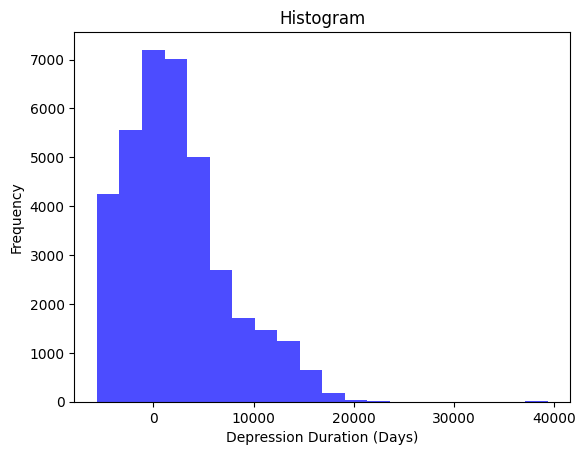

In [27]:
#check depression duration variable with histogram
plt.hist(pdf_rename['dep_dur'], bins=20, color='blue', alpha=0.7) 
plt.xlabel('Depression Duration (Days)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [28]:
#fill empty rows in white_yes with 0; some 0 variables did not convert correctly and need manual imput
pdf_rename['white_yes'].fillna(0, inplace=True)

In [29]:
#

In [30]:
#calculate baseline data

In [31]:
#create comorbidity covariate in multiple steps

In [32]:
#convert comorbidity diagnosis dates to datetime format
pdf_rename["i10_date"] = pd.to_datetime(pdf_rename["i10_date"])
pdf_rename["i15_date"] = pd.to_datetime(pdf_rename["i15_date"])
pdf_rename["e78_date"] = pd.to_datetime(pdf_rename["e78_date"])
pdf_rename["e10_date"] = pd.to_datetime(pdf_rename["e10_date"])
pdf_rename["e11_date"] = pd.to_datetime(pdf_rename["e11_date"])
pdf_rename["i50_date"] = pd.to_datetime(pdf_rename["i50_date"])
pdf_rename["i25_date"] = pd.to_datetime(pdf_rename["i25_date"])

In [33]:
#create hypertension category
#prep htn cases
pdf_rename['i10_time'] = (pdf_rename['date_i0'] - pdf_rename['i10_date']).dt.days
pdf_rename['i15_time'] = (pdf_rename['date_i0'] - pdf_rename['i15_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i10_time'] > 0 or row['i15_time'] > 0 or '1065' in row['sr_illness'] or '1072' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['htn_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [34]:
#create heart failure category
#prep  cases
pdf_rename['i50_time'] = (pdf_rename['date_i0'] - pdf_rename['i50_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i50_time'] > 0  or '1076' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['hf_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [35]:
#create cad category
#prep  cases
pdf_rename['i25_time'] = (pdf_rename['date_i0'] - pdf_rename['i25_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i25_time'] > 0:
        return 1
    else:
        return 0

pdf_rename['cad_yes'] = pdf_rename.apply(check_htn_criteria, axis=1)

In [36]:
#create cancer covariate
pdf_rename['cancer_yes'] = pdf_rename['p134_i0'].apply(lambda x: 1 if x > 0 else 0)

In [37]:
#create hyperlipidemia category
#prep hchol cases
pdf_rename['e78_time'] = (pdf_rename['date_i0'] - pdf_rename['e78_date']).dt.days
def check_hchol_criteria(row):
    if row['e78_time'] > 0 or '1473' in row['sr_illness']:
        return 1
    else:
        return 0
    
pdf_rename['hchol_yes'] = pdf_rename.apply(check_hchol_criteria, axis=1)

In [38]:
#create diabetes category
#prep diabetes cases
pdf_rename['e10_date'] = pd.to_datetime(pdf_rename['e10_date'])
pdf_rename['e11_date'] = pd.to_datetime(pdf_rename['e11_date'])
pdf_rename['date_i0'] = pd.to_datetime(pdf_rename['date_i0'])
pdf_rename['e10_time'] = (pdf_rename['date_i0'] - pdf_rename['e10_date']).dt.days
pdf_rename['e11_time'] = (pdf_rename['date_i0'] - pdf_rename['e11_date']).dt.days

def check_diab_criteria(row):
    if row['e10_time'] > 0 or row['e11_time'] > 0 or '1222' in row['sr_illness'] or '1223' in row['sr_illness']:
        return 1
    else:
        return 0

pdf_rename['diab_yes'] = pdf_rename.apply(check_diab_criteria, axis=1)

In [39]:
#create comorbidity covariate for analysis and filter covariate for baseline characteristics table considering set of comorbidities created above
pdf_rename['comorb_sum'] = pdf_rename[['htn_yes', 'hf_yes', 'cad_yes', 'cancer_yes', 'hchol_yes', 'diab_yes']].sum(axis=1)
pdf_rename['comorb_sum_filter'] = pdf_rename['comorb_sum'].apply(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

In [40]:
#prep clean cevd endpoint variable as first day in px chart with CeVD diagnosis after accelerometer study

In [41]:
#if assessment date - event date < 0, then copy absolute value to corresponding column
pdf_rename.loc[pdf_rename['f01_time'] < 0, 'f01_t2e'] = abs(pdf_rename['f01_time'])
pdf_rename.loc[pdf_rename['g45_time'] < 0, 'g45_t2e'] = abs(pdf_rename['g45_time'])
pdf_rename.loc[pdf_rename['g46_time'] < 0, 'g46_t2e'] = abs(pdf_rename['g46_time'])
pdf_rename.loc[pdf_rename['h34_time'] < 0, 'h34_t2e'] = abs(pdf_rename['h34_time'])
pdf_rename.loc[pdf_rename['i60_time'] < 0, 'i60_t2e'] = abs(pdf_rename['i60_time'])
pdf_rename.loc[pdf_rename['i61_time'] < 0, 'i61_t2e'] = abs(pdf_rename['i61_time'])
pdf_rename.loc[pdf_rename['i62_time'] < 0, 'i62_t2e'] = abs(pdf_rename['i62_time'])
pdf_rename.loc[pdf_rename['i63_time'] < 0, 'i63_t2e'] = abs(pdf_rename['i63_time'])
pdf_rename.loc[pdf_rename['i64_time'] < 0, 'i64_t2e'] = abs(pdf_rename['i64_time'])
pdf_rename.loc[pdf_rename['i65_time'] < 0, 'i65_t2e'] = abs(pdf_rename['i65_time'])
pdf_rename.loc[pdf_rename['i66_time'] < 0, 'i66_t2e'] = abs(pdf_rename['i66_time'])
pdf_rename.loc[pdf_rename['i67_time'] < 0, 'i67_t2e'] = abs(pdf_rename['i67_time'])
pdf_rename.loc[pdf_rename['i68_time'] < 0, 'i68_t2e'] = abs(pdf_rename['i68_time'])
pdf_rename.loc[pdf_rename['i69_time'] < 0, 'i69_t2e'] = abs(pdf_rename['i69_time'])

In [42]:
#if there is a time-to-event in XXX_t2e, then place 1 in outcome column for each CeVD
pdf_rename.loc[pdf_rename['f01_t2e'].notna(), 'f01_event'] = 1
pdf_rename.loc[pdf_rename['g45_t2e'].notna(), 'g45_event'] = 1
pdf_rename.loc[pdf_rename['g46_t2e'].notna(), 'g46_event'] = 1
pdf_rename.loc[pdf_rename['h34_t2e'].notna(), 'h34_event'] = 1
pdf_rename.loc[pdf_rename['i60_t2e'].notna(), 'i60_event'] = 1
pdf_rename.loc[pdf_rename['i61_t2e'].notna(), 'i61_event'] = 1
pdf_rename.loc[pdf_rename['i62_t2e'].notna(), 'i62_event'] = 1
pdf_rename.loc[pdf_rename['i63_t2e'].notna(), 'i63_event'] = 1
pdf_rename.loc[pdf_rename['i64_t2e'].notna(), 'i64_event'] = 1
pdf_rename.loc[pdf_rename['i65_t2e'].notna(), 'i65_event'] = 1
pdf_rename.loc[pdf_rename['i66_t2e'].notna(), 'i66_event'] = 1
pdf_rename.loc[pdf_rename['i67_t2e'].notna(), 'i67_event'] = 1
pdf_rename.loc[pdf_rename['i68_t2e'].notna(), 'i68_event'] = 1
pdf_rename.loc[pdf_rename['i69_t2e'].notna(), 'i69_event'] = 1

In [43]:
#create composite cevd outcome value
pdf_rename.loc[(pdf_rename['f01_event'].notna()) | (pdf_rename['g45_event'].notna()) | (pdf_rename['g46_event'].notna()) | (pdf_rename['h34_event'].notna()) | (pdf_rename['i60_event'].notna()) | (pdf_rename['i61_event'].notna()) | (pdf_rename['i62_event'].notna()) | (pdf_rename['i63_event'].notna()) | (pdf_rename['i64_event'].notna()) | (pdf_rename['i65_event'].notna()) | (pdf_rename['i66_event'].notna()) | (pdf_rename['i67_event'].notna()) | (pdf_rename['i68_event'].notna()) | (pdf_rename['i69_event'].notna()), 'cevd_event'] = 1
pdf_rename['cevd_event'] = pdf_rename['cevd_event'].fillna(0)

#check number of future cevd_events 
sum_cevdevents = pdf_rename['cevd_event'].sum()
print('Number of CeVD events (total)', sum_cevdevents)

Number of CeVD events (total) 14508.0


In [44]:
#create cevd time-to-event value for earliest cevd event
pdf_rename['cevd_t2e'] = pdf_rename[['f01_t2e', 'g45_t2e', 'g46_t2e', 'h34_t2e', 'i60_t2e', 'i61_t2e', 'i62_t2e', 'i63_t2e', 'i64_t2e', 'i65_t2e', 'i66_t2e', 'i67_t2e', 'i68_t2e', 'i69_t2e']].min(axis=1)

In [45]:
#convert all t2e columns to numeric for filtering
def convert_t2e_to_numeric(df):
    df['f01_t2e'] = pd.to_numeric(df['f01_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['g45_t2e'] = pd.to_numeric(df['g45_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['g46_t2e'] = pd.to_numeric(df['g46_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['h34_t2e'] = pd.to_numeric(df['h34_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i60_t2e'] = pd.to_numeric(df['i60_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i61_t2e'] = pd.to_numeric(df['i61_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i62_t2e'] = pd.to_numeric(df['i62_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i63_t2e'] = pd.to_numeric(df['i63_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i64_t2e'] = pd.to_numeric(df['i64_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i65_t2e'] = pd.to_numeric(df['i65_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i66_t2e'] = pd.to_numeric(df['i66_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i67_t2e'] = pd.to_numeric(df['i67_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i68_t2e'] = pd.to_numeric(df['i68_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['i69_t2e'] = pd.to_numeric(df['i69_t2e'], errors='coerce').astype(pd.Int64Dtype())
    df['cevd_t2e'] = pd.to_numeric(df['cevd_t2e'], errors='coerce').astype(pd.Int64Dtype())
    return df

pdf_rename = convert_t2e_to_numeric(pdf_rename)

In [46]:
#clean all cevd types to only have t2e for the initial CeVD diagnosis after accelerometer study commencement
def check_cevd_types(df):
    for index, row in df.iterrows():
        if pd.notna(row['f01_t2e']):
            if row['f01_t2e'] != row['cevd_t2e']:
                df.at[index, 'f01_t2e'] = None
        if pd.notna(row['g45_t2e']):
            if row['g45_t2e'] != row['cevd_t2e']:
                 df.at[index, 'g45_t2e'] = None
        if pd.notna(row['g46_t2e']):
            if row['g46_t2e'] != row['cevd_t2e']:
                 df.at[index, 'g46_t2e'] = None
        if pd.notna(row['h34_t2e']):
            if row['h34_t2e'] != row['cevd_t2e']:
                 df.at[index, 'h34_t2e'] = None
        if pd.notna(row['i60_t2e']):
            if row['i60_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i60_t2e'] = None
        if pd.notna(row['i61_t2e']):
            if row['i61_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i61_t2e'] = None
        if pd.notna(row['i62_t2e']):
            if row['i62_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i62_t2e'] = None
        if pd.notna(row['i63_t2e']):
            if row['i63_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i63_t2e'] = None
        if pd.notna(row['i64_t2e']):
            if row['i64_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i64_t2e'] = None
        if pd.notna(row['i65_t2e']):
            if row['i65_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i65_t2e'] = None
        if pd.notna(row['i66_t2e']):
            if row['i66_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i66_t2e'] = None
        if pd.notna(row['i67_t2e']):
            if row['i67_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i67_t2e'] = None
        if pd.notna(row['i68_t2e']):
            if row['i68_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i68_t2e'] = None
        if pd.notna(row['i69_t2e']):
            if row['i69_t2e'] != row['cevd_t2e']:
                 df.at[index, 'i69_t2e'] = None
    return df

cevd_df_first = check_cevd_types(pdf_rename)

In [47]:
#get the number of missing BMI values for imputation
missing_bmi = cevd_df_first['bmi'].isna().sum()
print('number of rows with missing BMI data:', missing_bmi)
#get the number of missing BMI values for imputation
missing_tdi = cevd_df_first['tdi'].isna().sum()
print('number of rows with missing TDI data:', missing_tdi)

number of rows with missing BMI data: 1215
number of rows with missing TDI data: 427


In [48]:
#USE MUTIPLE CHAIN IMPUTATION FOR MISSING BMI DATA
cols_to_impute = ['bmi', 'tdi']
# create an instance of the IterativeImputer class with MICE algorithm
imputer = IterativeImputer(max_iter=10, sample_posterior=True)
# impute the selected columns using multiple chains
cevd_df_first[cols_to_impute] = imputer.fit_transform(cevd_df_first[cols_to_impute])

In [49]:
#create a value with the day of intitial CeVD diagnosis after accelerometer study commencement
def find_firstday_cevd(row):
    dates = [row['f01_date'], row['g45_date'], row['g46_date'], row['h34_date'], row['i60_date'], row['i61_date'], row['i62_date'], row['i63_date'], row['i64_date'], row['i65_date'], row['i66_date'], row['i67_date'], row['i68_date'], row['i69_date']]
    non_empty_dates = [date for date in dates if not pd.isnull(date)]
    return min(non_empty_dates) if non_empty_dates else pd.NaT

cevd_df_first['cevd_day'] = cevd_df_first.apply(find_firstday_cevd, axis=1)

In [50]:
print('confirming the df length is 307,008 (complete) after wrangling', len(cevd_df_first))

confirming the df length is 307,008 (complete) after wrangling 307008


In [51]:
#check the number of px with a future CeVD in cohort
total_futurecevd = cevd_df_first[cevd_df_first['cevd_event']==1]
print('Number of patients in cohort with a future CeVD:', len(total_futurecevd))

Number of patients in cohort with a future CeVD: 14508


In [52]:
#create screen use covariate in multiple steps
screen_column = ['computer', 'tv', 'mobile phone']
cevd_df_first['tv'] = cevd_df_first['tv'].replace(-10, 0.5)
cevd_df_first['computer'] = cevd_df_first['computer'].replace(-10, 0.5)
cevd_df_first[screen_column] = cevd_df_first[screen_column].astype(int)

In [53]:
#reorder mobile phone use per week values 
#convert to hours or percentage of hours tied to 
cevd_df_first['mobile phone_filter'] = np.where(cevd_df_first['mobile phone'].isin([5]), 6, 
                    np.where(cevd_df_first['mobile phone'].isin([4]), 4,
                    np.where(cevd_df_first['mobile phone'].isin([3]), 2,
                    np.where(cevd_df_first['mobile phone'].isin([2]), 0.742, 
                    np.where(cevd_df_first['mobile phone'].isin([1]), 0.2, 
                             np.where(cevd_df_first['mobile phone'].isin([0]), 0.083, np.nan))))))

In [54]:
#screentime per day
cevd_df_first['full_screen_time'] = (cevd_df_first['computer']*1) + (cevd_df_first['tv']*1) + (cevd_df_first['mobile phone']/7)
cevd_df_first['full_screen_time'].head(4)

3    6.285714
7    3.142857
8    7.142857
9    3.142857
Name: full_screen_time, dtype: float64

In [55]:
total_futurecevd = cevd_df_first[cevd_df_first['cevd_event']==0]
print('number of non-future CeVD px:', len(total_futurecevd))

number of non-future CeVD px: 292500


In [56]:
#screen time per day filter; greater than 2 = 0
def assign_value(x):
    if x <= 2:
        return 1
    else:
        return 0

cevd_df_first['full_screen_time_filter'] = cevd_df_first['full_screen_time'].apply(assign_value)

In [57]:
cevd_df_first_onlycevd = cevd_df_first.dropna(subset=['cevd_day'])
print('Number of px in first part of longitudinal analysis:', len(cevd_df_first_onlycevd))

Number of px in first part of longitudinal analysis: 14508


In [58]:
#to csv for dataframe for baseline cross-sectional analysis
cevd_df_first_onlycevd.to_csv('cevd_first_model.csv', index=False)

In [59]:
#create second part of longitudinal analysis

In [60]:
cevd_df_second = cevd_df_first_onlycevd.dropna(subset=['date_i1'])
len(cevd_df_second)

624

In [61]:
cevd_df_second = cevd_df_second.dropna(subset=['phq2_1_followup'])
len(cevd_df_second)

624

In [62]:
cevd_df_second['cevd_day'] = pd.to_datetime(cevd_df_second['cevd_day'])
cevd_df_second['cevd_before_i1'] = np.where(cevd_df_second['cevd_day'] < cevd_df_second['date_i1'], 1, 0)
len(cevd_df_second)

624

In [63]:
cevd_df_second = cevd_df_second.drop(cevd_df_second.loc[cevd_df_second['phq2_1_followup'] < -1].index)
cevd_df_second['phq2_1_followup'] = cevd_df_second['phq2_1_followup'].replace(-1, 0)
len(cevd_df_second)

623

In [64]:
#cevd_df_second['met_minweek_1'] = pd.to_numeric(cevd_df_second['met_minweek_1'], errors='coerce')
#cevd_df_second['met_minweek_filter_1'] = cevd_df_second['met_minweek_1']/7
#cevd_df_second['met_minweek_filter_1'] = cevd_df_second['met_minweek_filter_1']/60

In [65]:
#convert sr_illness to string
cevd_df_second['sr_illness_1'].dtype
cevd_df_second['sr_illness_1'] = cevd_df_second['sr_illness_1'].astype(str)

In [66]:
#drop -1 ("do not know") and -3 ("prefer not to answer") from sleep duration survey
cevd_df_second = cevd_df_second[~(cevd_df_second['sleep_1'] == -3)]
cevd_df_second = cevd_df_second[~(cevd_df_second['sleep_1'] == -1)]
print('after dropping px with missing sleep survey data', len(cevd_df_second))

after dropping px with missing sleep survey data 622


In [67]:
#for smoking status, drop anyone who answered "-3/prefer not to answer"
cevd_df_second['smok_stat_1'] = cevd_df_second['smok_stat_1'].astype(str)
cevd_df_second = cevd_df_second[~cevd_df_second['smok_stat_1'].str.contains('-3')]
print('after dropping px with missing smoking survey data', len(cevd_df_second))

after dropping px with missing smoking survey data 620


In [68]:
#drop -1 and -3 from tv and computer and mobile phone use; fix tv use value of -10
cevd_df_second = cevd_df_second[~(cevd_df_second['tv_1'] == -3)]
cevd_df_second = cevd_df_second[~(cevd_df_second['tv_1'] == -1)]
cevd_df_second = cevd_df_second[~(cevd_df_second['computer_1'] == -3)]
cevd_df_second = cevd_df_second[~(cevd_df_second['computer_1'] == -1)]
cevd_df_second = cevd_df_second[~(cevd_df_second['mobile phone_1'] == -3)]
cevd_df_second = cevd_df_second[~(cevd_df_second['mobile phone_1'] == -1)]
cevd_df_second['tv_1'] = cevd_df_second['tv_1'].replace(-10, 0.5)
print('after dropping px with incomplete screen surveys data', len(cevd_df_second))
cevd_df_second.dropna(subset=['computer_1', 'tv_1', 'mobile phone_1'], inplace=True)
print('after dropping px with missing screen survey data', len(cevd_df_second))

after dropping px with incomplete screen surveys data 618
after dropping px with missing screen survey data 603


In [69]:
#drop alc_freq values for "prefer not to answer"/-3
cevd_df_second = cevd_df_second[~(cevd_df_second['alc_freq_1'] == -3)]
print('after dropping px with incomplete alcohol survey data', len(cevd_df_second))

after dropping px with incomplete alcohol survey data 603


In [70]:
#reorder alc_freq values 
#if 4	One to three times a month | 5	Special occasions only | 6	Never, then make seldom=1
#if 2	Three or four times a week | 3	Once or twice a week, then make sometimes=2
#if 1	Daily or almost daily, then make daily=3
cevd_df_second['alc_freq_filter_1'] = np.where(cevd_df_second['alc_freq_1'].isin([4, 5, 6]), 1, 
                    np.where(cevd_df_second['alc_freq_1'].isin([2, 3]), 2, 
                             np.where(cevd_df_second['alc_freq_1'].isin([1]), 3, np.nan)))

In [71]:
#drop phq2 scores where response was "-3/prefer not to answer"
cevd_df_second = cevd_df_second.drop(cevd_df_second.loc[cevd_df_second['phq2_1_followup'] < -1].index)
len(cevd_df_second)

603

In [72]:
# replace all occurrences of -1 (do not know if depressed) in column PHQ2_1 and PHQ2_2 with 0
cevd_df_second['phq2_1'] = cevd_df_second['phq2_1'].replace(-1, 0)
len(cevd_df_second)

603

In [73]:
#create screen use covariate in multiple steps
screen_column_1 = ['computer_1', 'tv_1', 'mobile phone_1']
cevd_df_second['tv_1'] = cevd_df_second['tv_1'].replace(-10, 0.5)
cevd_df_second['computer_1'] = cevd_df_second['computer_1'].replace(-10, 0.5)
cevd_df_second[screen_column_1] = cevd_df_second[screen_column_1].astype(int)

In [74]:
#reorder mobile phone use per week values 
#convert to hours or percentage of hours tied to 
cevd_df_second['mobile phone_filter_1'] = np.where(cevd_df_second['mobile phone_1'].isin([5]), 6, 
                    np.where(cevd_df_second['mobile phone_1'].isin([4]), 4,
                    np.where(cevd_df_second['mobile phone_1'].isin([3]), 2,
                    np.where(cevd_df_second['mobile phone_1'].isin([2]), 0.742, 
                    np.where(cevd_df_second['mobile phone_1'].isin([1]), 0.2, 
                             np.where(cevd_df_second['mobile phone_1'].isin([0]), 0.083, np.nan))))))

In [75]:
#screentime per day
cevd_df_second['full_screen_time_1'] = (cevd_df_second['computer_1']*1) + (cevd_df_second['tv_1']*1) + (cevd_df_second['mobile phone_1']/7)
cevd_df_second['full_screen_time_1'].head(4)
#screen time per day filter; greater than 2 = 0
def assign_value(x):
    if x <= 2:
        return 1
    else:
        return 0

cevd_df_second['full_screen_time_filter_1'] = cevd_df_second['full_screen_time_1'].apply(assign_value)

In [76]:
cevd_df_second["date_i1"] = pd.to_datetime(cevd_df_second["date_i1"])
#create hypertension category
#prep htn cases
cevd_df_second['i10_time'] = (cevd_df_second['date_i1'] - cevd_df_second['i10_date']).dt.days
cevd_df_second['i15_time'] = (cevd_df_second['date_i1'] - cevd_df_second['i15_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i10_time'] > 0 or row['i15_time'] > 0:
        return 1
    else:
        return 0

cevd_df_second['htn_yes_1'] = cevd_df_second.apply(check_htn_criteria, axis=1)

In [77]:
#create heart failure category
#prep  cases
cevd_df_second['i50_time'] = (cevd_df_second['date_i1'] - cevd_df_second['i50_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i50_time'] > 0  or '1076' in row['sr_illness_1']:
        return 1
    else:
        return 0

cevd_df_second['hf_yes_1'] = cevd_df_second.apply(check_htn_criteria, axis=1)

In [78]:
#create cad category
#prep  cases
cevd_df_second['i25_time'] = (cevd_df_second['date_i1'] - cevd_df_second['i25_date']).dt.days

# check for htn; if yes, return 1
def check_htn_criteria(row):
    if row['i25_time'] > 0:
        return 1
    else:
        return 0

cevd_df_second['cad_yes_1'] = cevd_df_second.apply(check_htn_criteria, axis=1)

In [79]:
#create cancer covariate
cevd_df_second['cancer_yes_1'] = cevd_df_second['p134_i1'].apply(lambda x: 1 if x > 0 else 0)

In [80]:
#create hyperlipidemia category
#prep hchol cases
cevd_df_second['e78_time'] = (cevd_df_second['date_i1'] - cevd_df_second['e78_date']).dt.days
def check_hchol_criteria(row):
    if row['e78_time'] > 0 or '1473' in row['sr_illness_1']:
        return 1
    else:
        return 0
    
cevd_df_second['hchol_yes_1'] = cevd_df_second.apply(check_hchol_criteria, axis=1)

In [81]:
#create diabetes category
#prep diabetes cases
cevd_df_second['e10_date'] = pd.to_datetime(cevd_df_second['e10_date'])
cevd_df_second['e11_date'] = pd.to_datetime(cevd_df_second['e11_date'])
cevd_df_second['e10_time'] = (cevd_df_second['date_i0'] - cevd_df_second['e10_date']).dt.days
cevd_df_second['e11_time'] = (cevd_df_second['date_i0'] - cevd_df_second['e11_date']).dt.days

def check_diab_criteria(row):
    if row['e10_time'] > 0 or row['e11_time'] > 0 or '1222' in row['sr_illness_1'] or '1223' in row['sr_illness_1']:
        return 1
    else:
        return 0

cevd_df_second['diab_yes_1'] = cevd_df_second.apply(check_diab_criteria, axis=1)

In [82]:
#create comorbidity covariate for analysis and filter covariate for baseline characteristics table considering set of comorbidities created above
cevd_df_second['comorb_sum_1'] = cevd_df_second[['htn_yes_1', 'hf_yes_1', 'cad_yes_1', 'cancer_yes_1', 'hchol_yes_1', 'diab_yes_1']].sum(axis=1)
cevd_df_second['comorb_sum_filter_1'] = cevd_df_second['comorb_sum_1'].apply(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

In [83]:
#prep depression cases in "days" format
cevd_df_second['f31_time'] = (cevd_df_second['date_i1'] - cevd_df_second['f31_date']).dt.days
cevd_df_second['f32_time'] = (cevd_df_second['date_i1'] - cevd_df_second['f32_date']).dt.days
cevd_df_second['f33_time'] = (cevd_df_second['date_i1'] - cevd_df_second['f33_date']).dt.days
# check for diagnosed depression; if yes, return 1
def check_for_dep_diag(row):
    if row['f31_time'] > 0 or row['f32_time'] > 0 or row['f33_time'] > 0:
        return 1
    else:
        return 0

cevd_df_second['dep_diag_yes_1'] = cevd_df_second.apply(check_for_dep_diag, axis=1)
check_dep_diag = cevd_df_second['dep_diag_yes_1'].sum()
print("Number of px with depression diagnosis (F31, F32, F33):", check_dep_diag)

Number of px with depression diagnosis (F31, F32, F33): 64


In [84]:
#to csv for dataframe for follow-up cross-sectional analysis
cevd_df_second.to_csv('cevd_second_model.csv', index=False)

In [85]:
print('Number of participants in baseline dataset:', len(cevd_df_first_onlycevd))
print('Number of participants in baseline dataset w/o depression:', len(cevd_df_first_onlycevd[(cevd_df_first_onlycevd['dep_diag_yes'] == 0)]))
print('Number of participants in baseline dataset w/depression:', len(cevd_df_first_onlycevd[(cevd_df_first_onlycevd['dep_diag_yes'] == 1)]))
print('Number of participants in follow-up dataset:', len(cevd_df_second))
print('Number of participants in follow-up dataset w/depression:', len(cevd_df_second[(cevd_df_second['dep_diag_yes_1'] == 1)]))
print('Number of participants in follow-up dataset w/o depression:', len(cevd_df_second[(cevd_df_second['dep_diag_yes_1'] == 0)]))
print('Number of participants in follow-up dataset w/cevd:', len(cevd_df_second['cevd_before_i1'] == 1))
print('Number of participants in follow-up dataset w/cevd w/dep:', len(cevd_df_second[(cevd_df_second['cevd_before_i1'] == 1) & (cevd_df_second['dep_diag_yes_1'] == 1)]))
print('Number of participants in follow-up dataset w/cevd w/o dep:', len(cevd_df_second[(cevd_df_second['cevd_before_i1'] == 1) & (cevd_df_second['dep_diag_yes_1'] == 0)]))

Number of participants in baseline dataset: 14508
Number of participants in baseline dataset w/o depression: 13106
Number of participants in baseline dataset w/depression: 1402
Number of participants in follow-up dataset: 603
Number of participants in follow-up dataset w/depression: 64
Number of participants in follow-up dataset w/o depression: 539
Number of participants in follow-up dataset w/cevd: 603
Number of participants in follow-up dataset w/cevd w/dep: 16
Number of participants in follow-up dataset w/cevd w/o dep: 105


In [86]:
def count_f31(df):
    new_df = pd.DataFrame(columns=df.columns) 
    
    for index, row in df.iterrows():
        value_1 = row['f31_time']
        value_2 = row['f32_time']
        value_3 = row['f33_time']
        
        if value_1 > 0 and (pd.isna(value_2) or value_2 < 0) and (pd.isna(value_3) or value_3 < 0):
            new_df = pd.concat([new_df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)
    
    new_df.reset_index(drop=True, inplace=True) 
    return new_df

count_f31 = count_f31(cevd_df_first_onlycevd)
print('Number of px with F31:', len(count_f31))

Number of px with F31: 38


In [87]:
def count_f32(df):
    new_df = pd.DataFrame(columns=df.columns) 
    
    for index, row in df.iterrows():
        value_1 = row['f31_time']
        value_2 = row['f32_time']
        value_3 = row['f33_time']
        
        if value_2 > 0 and (pd.isna(value_1) or value_1 < 0) and (pd.isna(value_3) or value_3 < 0):
            new_df = pd.concat([new_df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)
    
    new_df.reset_index(drop=True, inplace=True)  # Reset the index of the new DataFrame
    return new_df

count_f32 = count_f32(cevd_df_first_onlycevd)
print('Number of px with F32:', len(count_f32))

Number of px with F32: 1240


In [88]:
def count_f33(df):
    new_df = pd.DataFrame(columns=df.columns) 
    
    for index, row in df.iterrows():
        value_1 = row['f31_time']
        value_2 = row['f32_time']
        value_3 = row['f33_time']
        
        if value_3 > 0 and (pd.isna(value_1) or value_1 < 0) and (pd.isna(value_2) or value_2 < 0):
            new_df = pd.concat([new_df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)
    
    new_df.reset_index(drop=True, inplace=True)  # Reset the index of the new DataFrame
    return new_df

count_f33 = count_f33(cevd_df_first_onlycevd)
print('Number of px with F33:', len(count_f33))

Number of px with F33: 26


In [89]:
#

In [90]:
#get baseline characteristics table

In [91]:
#

In [92]:
len(cevd_df_first_onlycevd[cevd_df_first_onlycevd['cevd_event'] == 1])

14508

In [93]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 1]
mean_age = subset['age_i0'].mean()
std_dev_age = subset['age_i0'].std()

print("Mean Age with exp cohort:", mean_age)
print("Standard Deviation of Age with exp cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['age_i0'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 0]
mean_age = subset['age_i0'].mean()
std_dev_age = subset['age_i0'].std()

print("Mean Age with control cohort:", mean_age)
print("Standard Deviation of Age with control cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['age_i0'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')

Mean Age with exp cohort: 58.86519258202568
Standard Deviation of Age with exp cohort: 6.96762787876629
P-value for tdi:
Mean Age with control cohort: 60.66641233023043
Standard Deviation of Age with control cohort: 6.788984697060469
P-value for tdi:


MannwhitneyuResult(statistic=210482064.0, pvalue=0.0)

In [94]:
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 1]
mean_age = subset['age_i1'].mean()
std_dev_age = subset['age_i1'].std()

print("Mean Age with exp cohort:", mean_age)
print("Standard Deviation of Age with exp cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_second['age_i1'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')
subset = cevd_df_second[cevd_df_second['dep_diag_yes'] == 0]
mean_age = subset['age_i1'].mean()
std_dev_age = subset['age_i1'].std()

print("Mean Age with control cohort:", mean_age)
print("Standard Deviation of Age with control cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_second['age_i1'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')

Mean Age with exp cohort: 61.359375
Standard Deviation of Age with exp cohort: 7.284179829853928
P-value for tdi:
Mean Age with control cohort: 64.87408759124088
Standard Deviation of Age with control cohort: 6.3306676514964195
P-value for tdi:


MannwhitneyuResult(statistic=363609.0, pvalue=6.172571257401554e-218)

In [95]:
#get male/female data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'male'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'male'].sum()
print('exp Cohort Percent male:', percent_male_d)
print('exp Cohort Total male:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'male'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'male'].sum()
print('Control Cohort Percent male:', percent_male_c)
print('Control Cohort Total male:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/18873)*100
print('% of men in total 18,873 cohort', perc_men_total)
data = pd.crosstab(cevd_df_first_onlycevd['male'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('MALE - Chi-square test statistic:', chi2_stat)
print('MALE - P-value:', p_val)

exp Cohort Percent male: 41.72610556348074
exp Cohort Total male: 585
Control Cohort Percent male: 57.54616206317718
Control Cohort Total male: 7542
% of men in total 18,873 cohort 43.06151645207439
MALE - Chi-square test statistic: 128.0125469757392
MALE - P-value: 1.1153563679554194e-29


In [96]:
#get male/female data
percent_male_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'male'].mean() * 100
male_sum_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'male'].sum()
print('exp Cohort Percent male:', percent_male_d)
print('exp Cohort Total male:', male_sum_d)
percent_male_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'male'].mean() * 100
male_sum_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'male'].sum()
print('Control Cohort Percent male:', percent_male_c)
print('Control Cohort Total male:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/18873)*100
print('% of men in total 18,873 cohort', perc_men_total)
data = pd.crosstab(cevd_df_second['male'], cevd_df_second['dep_diag_yes_1']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('MALE - Chi-square test statistic:', chi2_stat)
print('MALE - P-value:', p_val)

exp Cohort Percent male: 53.125
exp Cohort Total male: 34
Control Cohort Percent male: 63.07977736549165
Control Cohort Total male: 340
% of men in total 18,873 cohort 1.9816669315954007
MALE - Chi-square test statistic: 2.0027357383020066
MALE - P-value: 0.1570155916970494


In [97]:
#get white/ethnicity data
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'white_yes'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'white_yes'].sum()
print('exp Cohort Percent white:', percent_male_d)
print('exp Cohort Total white:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'white_yes'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'white_yes'].sum()
print('Control Cohort Percent white:', percent_male_c)
print('Control Cohort Total white:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/76505)*100
print('% of white in total 76505 cohort', perc_men_total)
data = pd.crosstab(cevd_df_first_onlycevd['white_yes'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('white - Chi-square test statistic:', chi2_stat)
print('white - P-value:', p_val)

exp Cohort Percent white: 97.21825962910128
exp Cohort Total white: 1363.0
Control Cohort Percent white: 95.11674042423317
Control Cohort Total white: 12466.0
% of white in total 76505 cohort 18.075942748839946
white - Chi-square test statistic: 12.071456950721432
white - P-value: 0.0005119967283486465


In [98]:
#get male/female data
percent_male_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'white_yes'].mean() * 100
male_sum_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'white_yes'].sum()
print('exp Cohort Percent white:', percent_male_d)
print('exp Cohort Total white:', male_sum_d)
percent_male_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'white_yes'].mean() * 100
male_sum_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'white_yes'].sum()
print('Control Cohort Percent white:', percent_male_c)
print('Control Cohort Total white:', male_sum_c)
perc_men_total = ((male_sum_d+male_sum_c)/18873)*100
print('% of men in total 18,873 cohort', perc_men_total)
data = pd.crosstab(cevd_df_second['white_yes'], cevd_df_second['dep_diag_yes_1']).to_numpy()
# chi-square test for independence for male data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('white - Chi-square test statistic:', chi2_stat)
print('white - P-value:', p_val)

exp Cohort Percent white: 96.875
exp Cohort Total white: 62.0
Control Cohort Percent white: 98.33024118738405
Control Cohort Total white: 530.0
% of men in total 18,873 cohort 3.1367562125788164
white - Chi-square test statistic: 0.10791030871755816
white - P-value: 0.7425358780269807


In [99]:
#get smoking data
cevd_df_first_onlycevd['smok_stat'] = pd.to_numeric(cevd_df_first_onlycevd['smok_stat'], errors='coerce').astype(pd.Int64Dtype())
cevd_df_first_onlycevd['smok_filter'] = cevd_df_first_onlycevd['smok_stat'].apply(lambda x: 1 if (x > 0) else 0)
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'smok_filter'].value_counts(normalize=True)
print('exp Percentages of smoke')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'smok_filter'].value_counts(normalize=True)
# print the value counts as percentages
print('CONTROL Percentages of smoke')
print(perc_alc_freq_c * 100)

data = pd.crosstab(cevd_df_first_onlycevd['smok_filter'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('smoke - Chi-square test statistic:', chi2_stat)
print('smoke - P-value:', p_val)

exp Percentages of smoke
1    55.563481
0    44.436519
Name: smok_filter, dtype: float64
CONTROL Percentages of smoke
1    52.945216
0    47.054784
Name: smok_filter, dtype: float64
smoke - Chi-square test statistic: 3.3828436559399275
smoke - P-value: 0.06587829990440892


/tmp/ipykernel_151/770987846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cevd_df_first_onlycevd['smok_stat'] = pd.to_numeric(cevd_df_first_onlycevd['smok_stat'], errors='coerce').astype(pd.Int64Dtype())
/tmp/ipykernel_151/770987846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cevd_df_first_onlycevd['smok_filter'] = cevd_df_first_onlycevd['smok_stat'].apply(lambda x: 1 if (x > 0) else 0)


In [100]:
#get smoking data
cevd_df_second['smok_stat_1'] = pd.to_numeric(cevd_df_second['smok_stat_1'], errors='coerce').astype(pd.Int64Dtype())
cevd_df_second['smok_filter_1'] = cevd_df_second['smok_stat_1'].apply(lambda x: 1 if (x > 0) else 0)
perc_alc_freq_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'smok_filter_1'].value_counts(normalize=True)
print('exp Percentages of smoke')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'smok_filter_1'].value_counts(normalize=True)
# print the value counts as percentages
print('CONTROL Percentages of smoke')
print(perc_alc_freq_c * 100)

data = pd.crosstab(cevd_df_second['smok_filter_1'], cevd_df_second['dep_diag_yes_1']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('smoke - Chi-square test statistic:', chi2_stat)
print('smoke - P-value:', p_val)

exp Percentages of smoke
0    62.5
1    37.5
Name: smok_filter_1, dtype: float64
CONTROL Percentages of smoke
0    53.246753
1    46.753247
Name: smok_filter_1, dtype: float64
smoke - Chi-square test statistic: 1.6182204517460128
smoke - P-value: 0.2033400988046694


In [101]:
#get bmi data
cevd_df_first_onlycevd['bmi_filter'] = cevd_df_first_onlycevd['bmi'].apply(lambda x: 1 if (x > 18.4 and x < 26) else 0)
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'bmi_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'bmi_filter'].sum()
print('exp Cohort Percent bmi:', percent_male_d)
print('exp Cohort Total bmi:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'bmi_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'bmi_filter'].sum()
print('Control Cohort Percent bmi:', percent_male_c)
print('Control Cohort Total bmi:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['bmi_filter'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence for bmi data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('bmi - Chi-square test statistic:', chi2_stat)
print('bmi - P-value:', p_val)

exp Cohort Percent bmi: 31.526390870185452
exp Cohort Total bmi: 442
Control Cohort Percent bmi: 37.65450938501449
Control Cohort Total bmi: 4935
bmi - Chi-square test statistic: 20.12833984771519
bmi - P-value: 7.241567990639089e-06


/tmp/ipykernel_151/1515765443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cevd_df_first_onlycevd['bmi_filter'] = cevd_df_first_onlycevd['bmi'].apply(lambda x: 1 if (x > 18.4 and x < 26) else 0)


In [102]:
#get bmi data
cevd_df_second['bmi_filter_1'] = cevd_df_second['bmi_1'].apply(lambda x: 1 if (x > 18.4 and x < 26) else 0)
percent_male_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 1, 'bmi_filter_1'].mean() * 100
male_sum_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 1, 'bmi_filter_1'].sum()
print('exp Cohort Percent bmi:', percent_male_d)
print('exp Cohort Total bmi:', male_sum_d)
percent_male_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 0, 'bmi_filter_1'].mean() * 100
male_sum_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 0, 'bmi_filter_1'].sum()
print('Control Cohort Percent bmi:', percent_male_c)
print('Control Cohort Total bmi:', male_sum_c)
data = pd.crosstab(cevd_df_second['bmi_filter_1'], cevd_df_second['dep_diag_yes']).to_numpy()
# chi-square test for independence for bmi data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('bmi - Chi-square test statistic:', chi2_stat)
print('bmi - P-value:', p_val)

exp Cohort Percent bmi: 21.818181818181817
exp Cohort Total bmi: 12
Control Cohort Percent bmi: 41.605839416058394
Control Cohort Total bmi: 228
bmi - Chi-square test statistic: 7.363302243627533
bmi - P-value: 0.00665684232507151


In [103]:
#get bmi data
cevd_df_first_onlycevd['sleep_filter'] = cevd_df_first_onlycevd['sleep'].apply(lambda x: 1 if (x > 7 and x < 9) else 0)
percent_male_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'sleep_filter'].mean() * 100
male_sum_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'sleep_filter'].sum()
print('exp Cohort Percent sleep:', percent_male_d)
print('exp Cohort Total sleep:', male_sum_d)
percent_male_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'sleep_filter'].mean() * 100
male_sum_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'sleep_filter'].sum()
print('Control Cohort Percent sleep:', percent_male_c)
print('Control Cohort Total sleep:', male_sum_c)
data = pd.crosstab(cevd_df_first_onlycevd['sleep_filter'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence for bmi data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('sleep - Chi-square test statistic:', chi2_stat)
print('sleep - P-value:', p_val)

exp Cohort Percent sleep: 28.459343794579173
exp Cohort Total sleep: 399
Control Cohort Percent sleep: 29.497939874866475
Control Cohort Total sleep: 3866
sleep - Chi-square test statistic: 0.6091339672802981
sleep - P-value: 0.435114073199547


/tmp/ipykernel_151/1927799745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cevd_df_first_onlycevd['sleep_filter'] = cevd_df_first_onlycevd['sleep'].apply(lambda x: 1 if (x > 7 and x < 9) else 0)


In [104]:
#get bmi data
cevd_df_second['sleep_filter_1'] = cevd_df_second['sleep_1'].apply(lambda x: 1 if (x > 7 and x < 9) else 0)
percent_male_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 1, 'sleep_filter_1'].mean() * 100
male_sum_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 1, 'sleep_filter_1'].sum()
print('exp Cohort Percent sleep:', percent_male_d)
print('exp Cohort Total sleep:', male_sum_d)
percent_male_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 0, 'sleep_filter_1'].mean() * 100
male_sum_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes'] == 0, 'sleep_filter_1'].sum()
print('Control Cohort Percent sleep:', percent_male_c)
print('Control Cohort Total sleep:', male_sum_c)
data = pd.crosstab(cevd_df_second['sleep_filter_1'], cevd_df_second['dep_diag_yes']).to_numpy()
# chi-square test for independence for bmi data
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('sleep - Chi-square test statistic:', chi2_stat)
print('sleep - P-value:', p_val)

exp Cohort Percent sleep: 30.909090909090907
exp Cohort Total sleep: 17
Control Cohort Percent sleep: 37.22627737226277
Control Cohort Total sleep: 204
sleep - Chi-square test statistic: 0.6085755551780765
sleep - P-value: 0.4353246434047967


In [105]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 1]
mean_age = subset['full_screen_time'].mean()
std_dev_age = subset['full_screen_time'].std()

print("Mean full_screen_time with exp cohort:", mean_age)
print("Standard Deviation of full_screen_time with exp cohort:", std_dev_age)
print('P-value for full_screen_time:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['full_screen_time'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 0]
mean_age = subset['full_screen_time'].mean()
std_dev_age = subset['full_screen_time'].std()

print("Mean full_screen_time with control cohort:", mean_age)
print("Standard Deviation of full_screen_time with control cohort:", std_dev_age)
print('P-value for full_screen_time:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['full_screen_time'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')

Mean full_screen_time with exp cohort: 4.502241695536988
Standard Deviation of full_screen_time with exp cohort: 2.5583438171403583
P-value for full_screen_time:
Mean full_screen_time with control cohort: 4.222809618277344
Standard Deviation of full_screen_time with control cohort: 2.2231832764100337
P-value for full_screen_time:


MannwhitneyuResult(statistic=209120125.0, pvalue=0.0)

In [106]:
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 1]
mean_age = subset['full_screen_time_1'].mean()
std_dev_age = subset['full_screen_time_1'].std()

print("Mean full_screen_time_1 with exp cohort:", mean_age)
print("Standard Deviation of full_screen_time_1 with exp cohort:", std_dev_age)
print('P-value for full_screen_time_1:')
stats.mannwhitneyu(x=cevd_df_second['full_screen_time_1'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 0]
mean_age = subset['full_screen_time_1'].mean()
std_dev_age = subset['full_screen_time_1'].std()

print("Mean full_screen_time_1 with control cohort:", mean_age)
print("Standard Deviation of full_screen_time_1 with control cohort:", std_dev_age)
print('P-value for full_screen_time_1:')
stats.mannwhitneyu(x=cevd_df_second['full_screen_time_1'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')

Mean full_screen_time_1 with exp cohort: 4.486607142857142
Standard Deviation of full_screen_time_1 with exp cohort: 2.2363893846452156
P-value for full_screen_time_1:
Mean full_screen_time_1 with control cohort: 4.538563477338988
Standard Deviation of full_screen_time_1 with control cohort: 2.257320598908777
P-value for full_screen_time_1:


MannwhitneyuResult(statistic=362681.0, pvalue=9.874833042004527e-216)

In [107]:
cevd_df_first_onlycevd['met_minweek_filter'] = pd.to_numeric(cevd_df_first_onlycevd['met_minweek_filter'], errors='coerce')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 1]
mean_age = subset['met_minweek_filter'].mean()
std_dev_age = subset['met_minweek_filter'].std()

print("Mean met with exp cohort:", mean_age)
print("Standard Deviation of met with exp cohort:", std_dev_age)
print('P-value for met:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['met_minweek_filter'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 0]
mean_age = subset['met_minweek_filter'].mean()
std_dev_age = subset['met_minweek_filter'].std()

print("Mean met with control cohort:", mean_age)
print("Standard Deviation of met with control cohort:", std_dev_age)

print('P-value for met:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['met_minweek_filter'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')

/tmp/ipykernel_151/2273173053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cevd_df_first_onlycevd['met_minweek_filter'] = pd.to_numeric(cevd_df_first_onlycevd['met_minweek_filter'], errors='coerce')


Mean met with exp cohort: 5.812286699273147
Standard Deviation of met with exp cohort: 6.352166994680101
P-value for met:
Mean met with control cohort: 6.542845007375757
Standard Deviation of met with control cohort: 6.600851839090991
P-value for met:


MannwhitneyuResult(statistic=205048665.0, pvalue=0.0)

In [108]:
cevd_df_second['met_minweek_filter'] = pd.to_numeric(cevd_df_second['met_minweek_filter'], errors='coerce')
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 1]
mean_age = subset['met_minweek_filter'].mean()
std_dev_age = subset['met_minweek_filter'].std()

print("Mean met with exp cohort:", mean_age)
print("Standard Deviation of met with exp cohort:", std_dev_age)
print('P-value for met:')
stats.mannwhitneyu(x=cevd_df_second['met_minweek_filter'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 0]
mean_age = subset['met_minweek_filter'].mean()
std_dev_age = subset['met_minweek_filter'].std()

print("Mean met with control cohort:", mean_age)
print("Standard Deviation of met with control cohort:", std_dev_age)

print('P-value for met:')
stats.mannwhitneyu(x=cevd_df_second['met_minweek_filter'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')

Mean met with exp cohort: 4.696119791666666
Standard Deviation of met with exp cohort: 4.235193053864862
P-value for met:
Mean met with control cohort: 5.9630766852195425
Standard Deviation of met with control cohort: 5.7445593324480475
P-value for met:


MannwhitneyuResult(statistic=354665.5, pvalue=1.4503357471739504e-198)

In [109]:
#subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes_1'] == 1]
#mean_age = subset['met_minweek_filter_1'].mean()
#std_dev_age = subset['met_minweek_filter_1'].std()

#print("Mean met with exp cohort:", mean_age)
#print("Standard Deviation of met with exp cohort:", std_dev_age)
#print('P-value for met:')
#stats.mannwhitneyu(x=cevd_df_first_onlycevd['met_minweek_filter_1'], y=cevd_df_first_onlycevd['dep_diag_yes_1'], alternative = 'two-sided')
#subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes_1'] == 0]
#mean_age = subset['met_minweek_filter_1'].mean()
#std_dev_age = subset['met_minweek_filter_1'].std()

#print("Mean met with control cohort:", mean_age)
#print("Standard Deviation of met with control cohort:", std_dev_age)
#print('P-value for met:')
#stats.mannwhitneyu(x=cevd_df_first_onlycevd['met_minweek_filter_1'], y=cevd_df_first_onlycevd['dep_diag_yes_1'], alternative = 'two-sided')

In [110]:
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 1]
mean_age = subset['tdi'].mean()
std_dev_age = subset['tdi'].std()

print("Mean tdi with exp cohort:", mean_age)
print("Standard Deviation of tdi with exp cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['tdi'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')
subset = cevd_df_first_onlycevd[cevd_df_first_onlycevd['dep_diag_yes'] == 0]
mean_age = subset['tdi'].mean()
std_dev_age = subset['tdi'].std()

print("Mean tdi with control cohort:", mean_age)
print("Standard Deviation of tdi with control cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_first_onlycevd['tdi'], y=cevd_df_first_onlycevd['dep_diag_yes'], alternative = 'two-sided')

Mean tdi with exp cohort: -0.6260640410075639
Standard Deviation of tdi with exp cohort: 3.4127689704131865
P-value for tdi:
Mean tdi with control cohort: -1.3366746369227531
Standard Deviation of tdi with control cohort: 3.0883912733794125
P-value for tdi:


MannwhitneyuResult(statistic=60386170.0, pvalue=0.0)

In [111]:
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 1]
mean_age = subset['tdi'].mean()
std_dev_age = subset['tdi'].std()

print("Mean tdi with exp cohort:", mean_age)
print("Standard Deviation of tdi with exp cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_second['tdi'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')
subset = cevd_df_second[cevd_df_second['dep_diag_yes_1'] == 0]
mean_age = subset['tdi'].mean()
std_dev_age = subset['tdi'].std()

print("Mean tdi with control cohort:", mean_age)
print("Standard Deviation of tdi with control cohort:", std_dev_age)
print('P-value for tdi:')
stats.mannwhitneyu(x=cevd_df_second['tdi'], y=cevd_df_second['dep_diag_yes_1'], alternative = 'two-sided')

Mean tdi with exp cohort: -0.8737500000000001
Standard Deviation of tdi with exp cohort: 3.4533799868148494
P-value for tdi:
Mean tdi with control cohort: -2.230037105751391
Standard Deviation of tdi with control cohort: 2.548273633586423
P-value for tdi:


MannwhitneyuResult(statistic=66502.0, pvalue=8.198966976390271e-89)

In [112]:
# get the %s of each category for alcohol frequency 
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'alc_freq_filter'].value_counts(normalize=True)
print('exp Percentages of alc freq')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'alc_freq_filter'].value_counts(normalize=True)
# print the value counts as percentages
print('econtrol Percentages of alc freq')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_first_onlycevd['alc_freq_filter'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('ALC FREQ - Chi-square test statistic:', chi2_stat)
print('ALC FREQ - P-value:', p_val)

exp Percentages of alc freq
1.0    40.299572
2.0    37.945792
3.0    21.754636
Name: alc_freq_filter, dtype: float64
econtrol Percentages of alc freq
2.0    46.383336
1.0    28.437357
3.0    25.179307
Name: alc_freq_filter, dtype: float64
ALC FREQ - Chi-square test statistic: 86.00577819644408
ALC FREQ - P-value: 2.1090290351575827e-19


In [113]:
# get the %s of each category for alcohol frequency 
perc_alc_freq_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'alc_freq_filter_1'].value_counts(normalize=True)
print('exp Percentages of alc freq')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'alc_freq_filter_1'].value_counts(normalize=True)
# print the value counts as percentages
print('econtrol Percentages of alc freq')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_second['alc_freq_filter_1'], cevd_df_second['dep_diag_yes_1']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('ALC FREQ - Chi-square test statistic:', chi2_stat)
print('ALC FREQ - P-value:', p_val)

exp Percentages of alc freq
2.0    50.0
1.0    37.5
3.0    12.5
Name: alc_freq_filter_1, dtype: float64
econtrol Percentages of alc freq
2.0    51.020408
1.0    27.087199
3.0    21.892393
Name: alc_freq_filter_1, dtype: float64
ALC FREQ - Chi-square test statistic: 4.627050349730823
ALC FREQ - P-value: 0.09891195431918683


In [114]:
# get comorbid filter data
perc_alc_freq_d = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 1, 'comorb_sum_filter'].value_counts(normalize=True)
print('exp Percentages of comorbid')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_first_onlycevd.loc[cevd_df_first_onlycevd['dep_diag_yes'] == 0, 'comorb_sum_filter'].value_counts(normalize=True)
print('CONTROL Percentages of comorbid')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_first_onlycevd['comorb_sum_filter'], cevd_df_first_onlycevd['dep_diag_yes']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('comorbid - Chi-square test statistic:', chi2_stat)
print('comorbid - P-value:', p_val)

exp Percentages of comorbid
0    41.298146
1    35.520685
2    23.181170
Name: comorb_sum_filter, dtype: float64
CONTROL Percentages of comorbid
0    46.841141
1    33.709751
2    19.449107
Name: comorb_sum_filter, dtype: float64
comorbid - Chi-square test statistic: 18.53431748872452
comorbid - P-value: 9.447656493148253e-05


In [115]:
# get comorbid filter data
perc_alc_freq_d = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 1, 'comorb_sum_filter_1'].value_counts(normalize=True)
print('exp Percentages of comorbid')
print(perc_alc_freq_d * 100)
perc_alc_freq_c = cevd_df_second.loc[cevd_df_second['dep_diag_yes_1'] == 0, 'comorb_sum_filter_1'].value_counts(normalize=True)
print('CONTROL Percentages of comorbid')
print(perc_alc_freq_c * 100)
data = pd.crosstab(cevd_df_second['comorb_sum_filter_1'], cevd_df_second['dep_diag_yes_1']).to_numpy()
# chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print('comorbid - Chi-square test statistic:', chi2_stat)
print('comorbid - P-value:', p_val)

exp Percentages of comorbid
2    35.9375
1    34.3750
0    29.6875
Name: comorb_sum_filter_1, dtype: float64
CONTROL Percentages of comorbid
0    36.920223
1    35.250464
2    27.829314
Name: comorb_sum_filter_1, dtype: float64
comorbid - Chi-square test statistic: 2.151154608340237
comorbid - P-value: 0.3411007795465394


In [116]:
#person year calculation if needed
#i69_days = cevd_df_first['i69_t2e'].sum()
#i69_personyears = i69_days/365
#print(i69_personyears)

In [117]:
#

In [118]:
#sensitivity analysis 1

In [119]:
#

In [ ]:
#drop all px on disability assistance
cevd_df_noassist = cevd_df_first[cevd_df_first['gov_assistance_filter']==0]
len(cevd_df_noassist)

KeyError: 'gov_assistance_filter'

In [ ]:
#drop all px with comorbidities
cevd_df_noassist_nocomor = cevd_df_noassist[cevd_df_noassist['comorb_sum_filter']==0]
len(cevd_df_noassist_nocomor)

In [ ]:
cevd_df_noassist_nocomor.to_csv('cevd_first_model_sa.csv', index=False)

In [ ]:
#

In [ ]:
#sensitivity analysis 2

In [ ]:
#

In [ ]:
#filter time to event for cevd for sa

In [ ]:
def filter_cevd_t2e(value):
    if pd.isna(value):
        return 0
    elif value < 1096:
        return 1
    elif 1096 <= value <= 1825:
        return 2
    else:
        return 3

cevd_df_first['cevd_t2e_filter'] = cevd_df_first['cevd_t2e'].apply(filter_cevd_t2e)

In [ ]:
cevd_0 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==0]
print('Number of px with no cevd:',len(cevd_0))

In [ ]:
cevd_1 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==1]
print('Number of px with cevd within 3 years of accelerometer study:',len(cevd_1))

In [ ]:
cevd_2 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==2]
print('Number of px with cevd between 3-5 years after accelerometer study:',len(cevd_2))

In [ ]:
cevd_3 = cevd_df_first[cevd_df_first['cevd_t2e_filter']==3]
print('Number of px with cevd 5 or more years after accelerometer study:',len(cevd_3))

In [ ]:
cevd_df_first.to_csv('cevd_first_model_sa_cevdt2e.csv', index=False)

In [ ]:
mean_t2e_cevd = cevd_df_first['cevd_t2e'].mean()
std_t2e_cevd = cevd_df_first['cevd_t2e'].std()

print('mean years from end of study to CeVD:', (mean_t2e_cevd/365))
print('std:', (std_t2e_cevd/365))

In [ ]:
#

In [ ]:
#sensitvity analysis 3

In [ ]:
#

In [ ]:
def filter_dep_dur(value):
    if pd.isna(value):
        return 0
    elif value < 1896:
        return 1
    elif 1896 <= value <= 3650:
        return 2
    else:
        return 3

cevd_df_first['dep_dur_filter'] = cevd_df_first['dep_dur'].apply(filter_dep_dur)

In [ ]:
dep_0 = cevd_df_first[cevd_df_first['dep_dur_filter']==0]
print('number of patients without depression diagnosis prior to accelerometer study:', len(dep_0))

In [ ]:
dep_1 = cevd_df_first[cevd_df_first['dep_dur_filter']==1]
print('number of patients with depression diagnosis within 5 yrs before accelerometer study:', len(dep_1))

In [ ]:
dep_2 = cevd_df_first[cevd_df_first['dep_dur_filter']==2]
print('number of patients with depression diagnosis conferred between 5 and 10 yrs before accelerometer study:', len(dep_2))

In [ ]:
dep_3 = cevd_df_first[cevd_df_first['dep_dur_filter']==3]
print('number of patients with depression diagnosis conferred 10 or more yrs before accelerometer study:', len(dep_3))

In [ ]:
mean_t2e_dep = cevd_df_first['dep_dur'].mean()
std_t2e_dep = cevd_df_first['dep_dur'].std()

print('mean years from dep diag to start of study:', (mean_t2e_dep/365))
print('std:', (std_t2e_dep/365))

In [ ]:
cevd_df_first.to_csv('cevd_first_model_sa_cevdt2eanddep.csv', index=False)

In [ ]:
#to upload on RAP UKBB
#%%bash
#dx upload <insert file name here>.ipynb --dest /

In [ ]:
#